<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe() 

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Проверим пропущенные значения
data.isna().sum()

num_orders    0
dtype: int64

In [7]:
# Проверим на монотонность
data.index.is_monotonic

True

In [8]:
# Ресемплирование по одному часу
data = data.resample("1H").sum()

In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**
- данные загружены
- выполнена проверка наличия пропущенных значений
- проверка на монотонность
- ресемплирование по часу

## Анализ

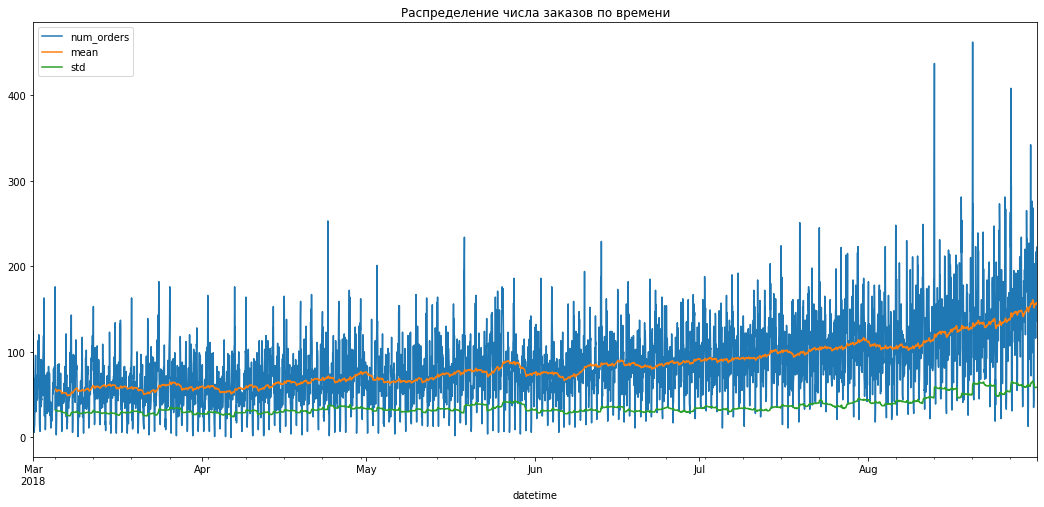

In [10]:
# Рассмотрим общий тренд
data_common = data.copy()

data_common['mean'] = data_common['num_orders'].rolling(100).mean() # скользящее среднее
data_common['std'] = data_common['num_orders'].rolling(100).std() # скользящее стандартное
data_common.plot(figsize=(18, 8), title = 'Распределение числа заказов по времени');

Можно заметить, что к концу августа среднее значение растет.

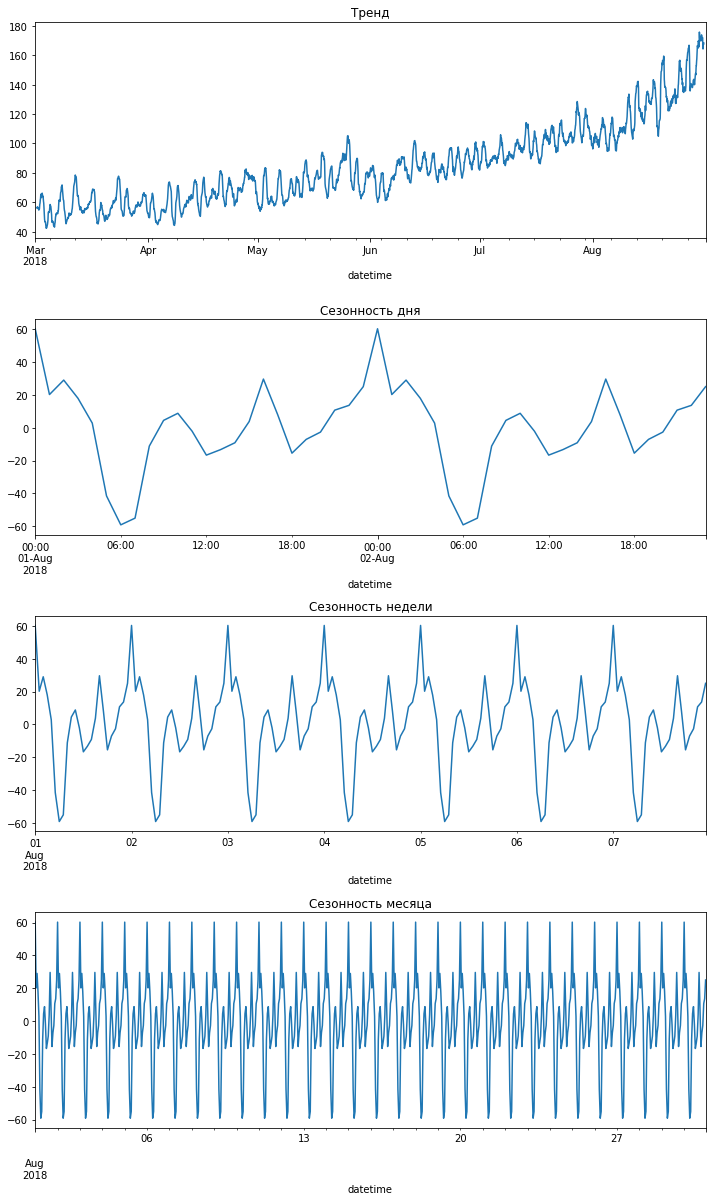

In [11]:
# Рассмотрим данные за август

decomposed = seasonal_decompose(data)
plt.figure(figsize=(10, 20))
plt.xlabel("Число заказов")
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(512)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Сезонность дня')
plt.subplot(513)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Сезонность недели') 
plt.subplot(514)
decomposed.seasonal['2018-08-01':'2018-08-30'].plot(ax=plt.gca())
plt.title('Сезонность месяца')
plt.tight_layout()

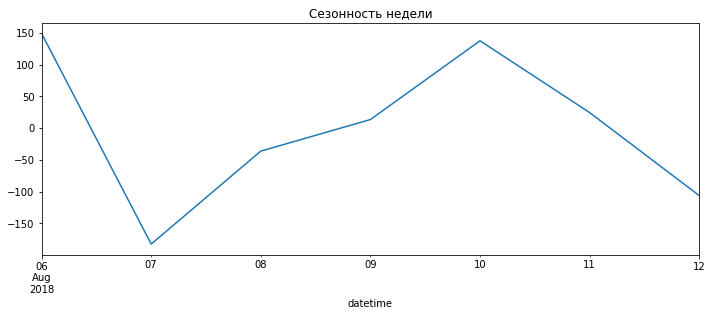

In [12]:
# Ресемплирование по дням недели
data_day_of_week =  data.copy()
data_day_of_week = data_day_of_week.resample("1D").sum()

decomposed = seasonal_decompose(data_day_of_week)
plt.figure(figsize=(10, 20))

plt.subplot(513)
decomposed.seasonal['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Сезонность недели') 

plt.tight_layout()

**Вывод**

По графику ***Тренд*** можно увидеть, что количество заказов такси увеличивается с начала марта по конец августа.


По графику ***Сезонность дня*** можно увидеть, что с 12 ночи до 6 утра идет спад (это и понятно, ведь ночью спрос меньше), также наблюдается несколько спадов в течение дня. Меньше всего заказов в 6 утра, больше всего - в 12 ночи.


Графики ***Сезонность за неделю*** и ***Сезонность месяца*** не показали изменение числа заказов в зависимости от дня недели. Это происходит, потому что ресемплирование проводилось по одному часу. 

По графику ***Сезонность недели*** можно сказать, что спрос меньше всего во вторник, больше всего - в понедельник и пятницу.

## Обучение

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 168, 30)

data = data.dropna()

In [14]:
RANDOM_STATE = 5000

# Разбиваем выборку на обучающую и тестовую
train, test = train_test_split(data, shuffle=False, test_size=0.2)

# Выделяем валидационную выборку
valid, test = train_test_split(test, shuffle=False, train_size=0.5)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1) 
features_test = test.drop('num_orders', axis=1) 

<div class="alert alert-block alert-success">
<b>Успех:</b> С разбиением все в порядке


</div>  

In [15]:
print('Размер обучающей выборки')
print(train.shape) 
print('Размер валидационной выборки')
print(valid.shape)
print('Размер тестовой выборки')
print(test.shape)

Размер обучающей выборки
(3398, 172)
Размер валидационной выборки
(425, 172)
Размер тестовой выборки
(425, 172)


In [16]:
print('Размер обучающей выборки - {:.0%}'.format(train.shape[0] / data.shape[0]))
print('Размер валидационной выборки- {:.0%}'.format(valid.shape[0] / data.shape[0]))
print('Размер тестовой выборки- {:.0%}'.format(test.shape[0] / data.shape[0]))

Размер обучающей выборки - 80%
Размер валидационной выборки- 10%
Размер тестовой выборки- 10%


In [17]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
train_RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE обучающей выборки =", train_RMSE)

RMSE обучающей выборки = 29.187015948798265


In [18]:
best_RMSE = 3000

best_depth = 0
best_samples_split = 2


for depth in range(2, 10):
    for samples_split in range(2,15):
    
        model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth, min_samples_split = samples_split) 
        model.fit(features_train, target_train)
    
        predictions_valid = model.predict(features_valid)

        train_RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
        
        print("RMSE:", train_RMSE, "Глубина дерева:", depth,"min_samples_split:", samples_split)

        if train_RMSE < best_RMSE:
            best_depth = depth
            best_RMSE = train_RMSE
            best_samples_split = samples_split


print()
print("RMSE обучающей выборки =", best_RMSE, "Глубина дерева:", best_depth, "min_samples_split:", best_samples_split)

RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 2
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 3
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 4
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 5
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 6
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 7
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 8
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 9
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 10
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 11
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 12
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 13
RMSE: 38.085780785778375 Глубина дерева: 2 min_samples_split: 14
RMSE: 36.958255647550594 Глубина дерева: 3 min_samples_split: 2
RMSE: 36.958255647550594 Глубина дерева: 3 min_samples_split: 3
RMSE: 36.958255647550594 Глубина де

In [19]:
best_RMSE = 3000

best_depth = 0
best_est = 0


for est in range(19, 21):
    for depth in range(10, 20):
    
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    
        predictions_valid = model.predict(features_valid) # предсказания модели на обучающей выборке
      
        train_RMSE = mean_squared_error(target_valid, predictions_valid)**0.5

        print("RMSE:", train_RMSE, "Количество деревьев:", est, "Глубина дерева:", depth)

        if train_RMSE < best_RMSE:
            best_depth = depth
            best_RMSE = train_RMSE
            best_est = est

print("RMSE обучающей выборки =", best_RMSE, "Количество деревьев:", best_est,  "Глубина дерева:", best_depth)

RMSE: 31.052094407068992 Количество деревьев: 19 Глубина дерева: 10
RMSE: 31.15525952560439 Количество деревьев: 19 Глубина дерева: 11
RMSE: 31.309302741479236 Количество деревьев: 19 Глубина дерева: 12
RMSE: 30.963499471053552 Количество деревьев: 19 Глубина дерева: 13
RMSE: 30.77898235549551 Количество деревьев: 19 Глубина дерева: 14
RMSE: 31.186081527490497 Количество деревьев: 19 Глубина дерева: 15
RMSE: 30.66787103941118 Количество деревьев: 19 Глубина дерева: 16
RMSE: 31.017261634536936 Количество деревьев: 19 Глубина дерева: 17
RMSE: 30.926615916756408 Количество деревьев: 19 Глубина дерева: 18
RMSE: 31.167643822143283 Количество деревьев: 19 Глубина дерева: 19
RMSE: 30.97693670627796 Количество деревьев: 20 Глубина дерева: 10
RMSE: 31.140477078732445 Количество деревьев: 20 Глубина дерева: 11
RMSE: 31.233341945818744 Количество деревьев: 20 Глубина дерева: 12
RMSE: 30.846721456991375 Количество деревьев: 20 Глубина дерева: 13
RMSE: 30.781381331530522 Количество деревьев: 20 Глу

In [20]:
best_RMSE = 3000
best_depth = 0
best_leaves = 0

for depth in range(3, 8, 2):
    for leaves in range(40, 43):
        model = lgb.LGBMRegressor(num_leaves = leaves,
                                  max_depth = depth,
                                  random_state=RANDOM_STATE,
                                  metric='rmse',
                                  task='train', 
                                  objective='regression',
                                  learning_rate=0.2,
                                  verbose=-1)


        model.fit(features_train, target_train)
    
        predictions_valid = model.predict(features_valid)
      
        train_RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
        
        print("RMSE:", train_RMSE,  "Количество листьев:", leaves,  "Глубина дерева:", depth)

        if train_RMSE < best_RMSE:
            best_depth = depth
            best_RMSE = train_RMSE
            best_leaves = leaves

print("RMSE обучающей выборки =", best_RMSE, "Количество листьев:", best_leaves,  "Глубина дерева:", best_depth)

RMSE: 30.98926748302929 Количество листьев: 40 Глубина дерева: 3
RMSE: 30.98926748302929 Количество листьев: 41 Глубина дерева: 3
RMSE: 30.98926748302929 Количество листьев: 42 Глубина дерева: 3
RMSE: 30.55232526074289 Количество листьев: 40 Глубина дерева: 5
RMSE: 30.55232526074289 Количество листьев: 41 Глубина дерева: 5
RMSE: 30.55232526074289 Количество листьев: 42 Глубина дерева: 5
RMSE: 30.723935504305338 Количество листьев: 40 Глубина дерева: 7
RMSE: 30.655701458754017 Количество листьев: 41 Глубина дерева: 7
RMSE: 30.86100334064025 Количество листьев: 42 Глубина дерева: 7
RMSE обучающей выборки = 30.55232526074289 Количество листьев: 40 Глубина дерева: 5


Лучший показатель RMSE = 29.187015948798265 у LinearRegression.

## Тестирование

In [21]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_test = model.predict(features_test)
test_RMSE = mean_squared_error(target_test, pred_test)**0.5

print("RMSE тестовой выборки = ", test_RMSE)

RMSE тестовой выборки =  34.63687062833992


**Вывод**

Значение RMSE для лучшей модели на тестовой выборке:
 - LinearRegression - 34.63687062833992

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48